In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
df = pd.read_excel('/content/drive/MyDrive/Time Series Studies/IPI.XLS')
df['mes/ano'] = pd.to_datetime(df['mês/ano'])

In [75]:
df['mes'] = df['mes/ano'].dt.month

In [76]:
data_inicial = pd.to_datetime('1993-01-01')
data_final = pd.to_datetime('1996-12-31')

df2 = df[(df['mês/ano'] >= data_inicial) & (df['mês/ano'] <= data_final)].reset_index(drop='True')

<Axes: >

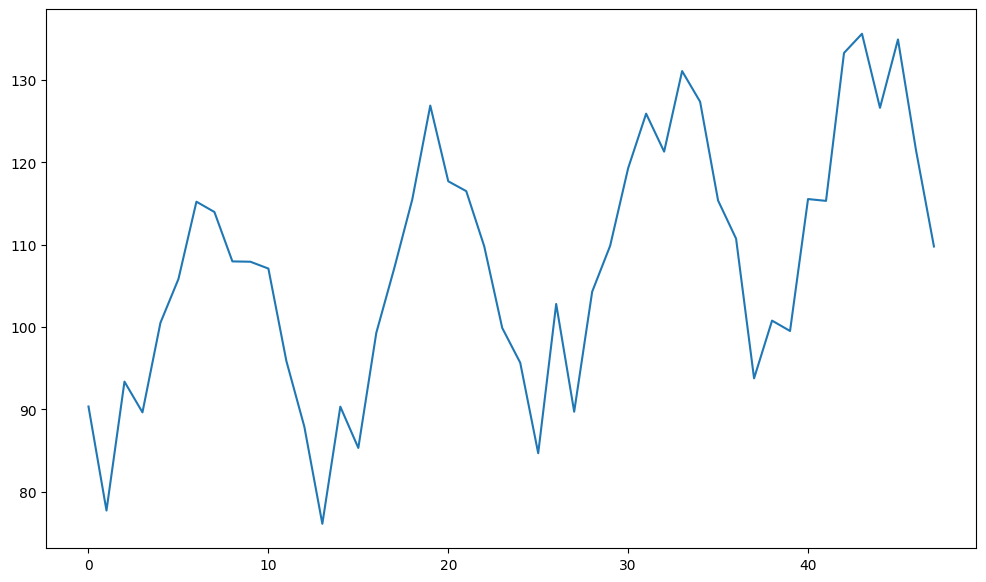

In [77]:
plt.figure(figsize = (12,7))
df2['ipialiment'].plot()

In [78]:
def design_sazo_matrix(length, sazo_periods, starts_in = 1):
  D = np.zeros((length, sazo_periods))

  count = starts_in - 1
  for i in range(length):
    D[i, count] = 1
    if count < sazo_periods - 1:
      count += 1
    else:
      count = 0
  return D


def polyfit_sazo(x_data, y_data, order, sazo_periods, starts_in = 1):
  aorder = order + 1
  b = np.array(y_data)
  A = np.ones((len(b), aorder))

  D = design_sazo_matrix(len(b),sazo_periods, starts_in)

  for i in range(1, aorder):
    A[:,i] = np.array(x_data) ** i

  A = np.hstack((A,D))

  lsq = np.linalg.lstsq(A, b.T, rcond = None)
  x = lsq[0]

  try:
    norm = lsq[1][0] ** (0.5)
    return [x , norm]
  except IndexError:
    mnorm = sum((np.dot(A, x) - b) ** 2) ** (0.5)
    return [x, mnorm]


def polyest_sazo(theta, x_data, sazo_periods, starts_in = 1):
  aorder = len(theta) - sazo_periods
  A = np.ones((len(x_data), aorder))
  D = design_sazo_matrix(len(x_data),sazo_periods, starts_in)

  for i in range(1, aorder):
    A[:,i] = np.array(x_data) ** i

  A = np.hstack((A,D))

  A_tend = A[:,0:aorder]
  theta_tend = theta[:aorder]
  Zest_tend = np.dot(A_tend, theta_tend)

  A_sazo = A[:,aorder:]
  theta_sazo = theta[aorder:]
  Zest_sazo = np.dot(A_sazo, theta_sazo)

  Zest = np.dot(A, theta)

  return Zest, Zest_tend, Zest_sazo

In [79]:
t = np.arange(1,np.array(len(df2)) + 1)
serie = df2['ipialiment']

nSamples = len(t)

nTestSamples = round(nSamples * 0.15)
nModel = nSamples - nTestSamples

# Separação de dados para modelagem
tModel = t[0:nModel]
ZtModel = serie[0:nModel]

# Separação de dados para teste
tTest = t[nModel:]
ZtTest = serie[nModel:]
month_start_test = df2.loc[tTest[0],'mes']

In [80]:
tend_order = 1
sazonalidade = df['mes'].nunique()

theta1 = polyfit_sazo(tModel,ZtModel,tend_order,sazonalidade)[0]
ZtModel1, ZtModel_tend, ZtModel_sazo = polyest_sazo(theta1,tModel,sazonalidade)

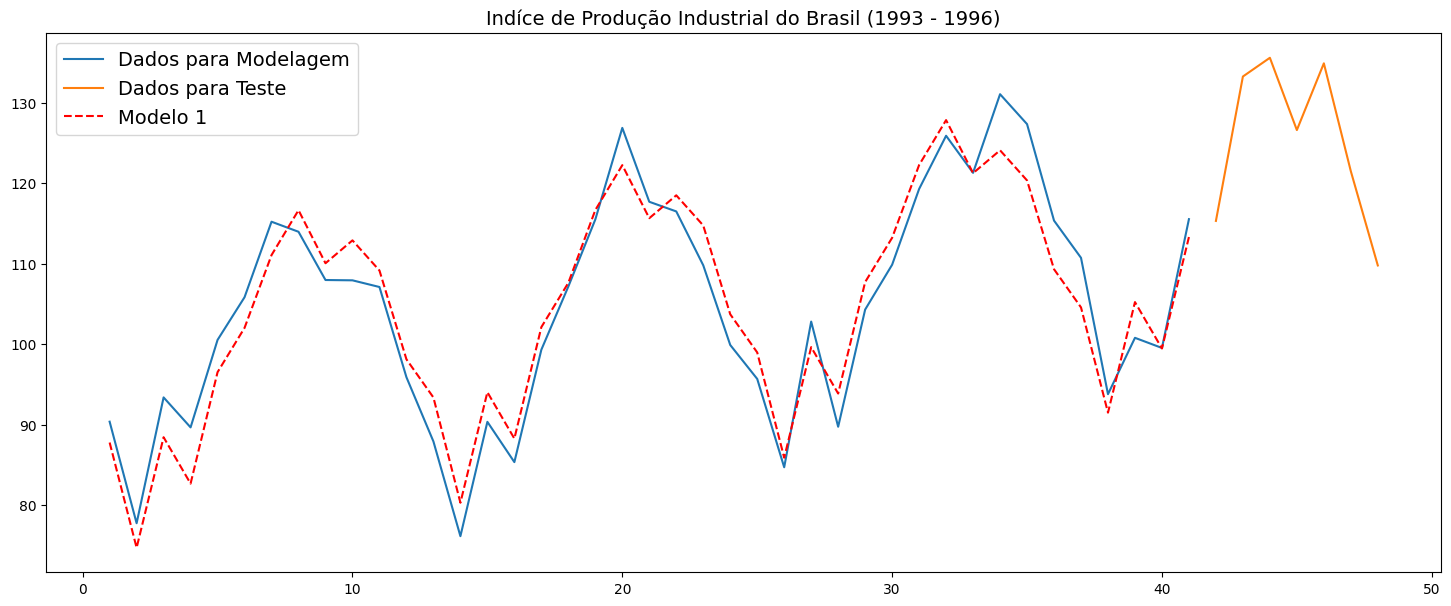

In [81]:
plt.figure(figsize = (18,7))
plt.plot(tModel,ZtModel, label = 'Dados para Modelagem')
plt.plot(tTest,ZtTest, label = 'Dados para Teste')
plt.plot(tModel,ZtModel1, color = 'red', linestyle = 'dashed', label = 'Modelo 1')


plt.title('Indíce de Produção Industrial do Brasil (1993 - 1996)', fontdict= {'size':14})
plt.legend(loc = 'upper left', prop = {'size':14})
plt.show()

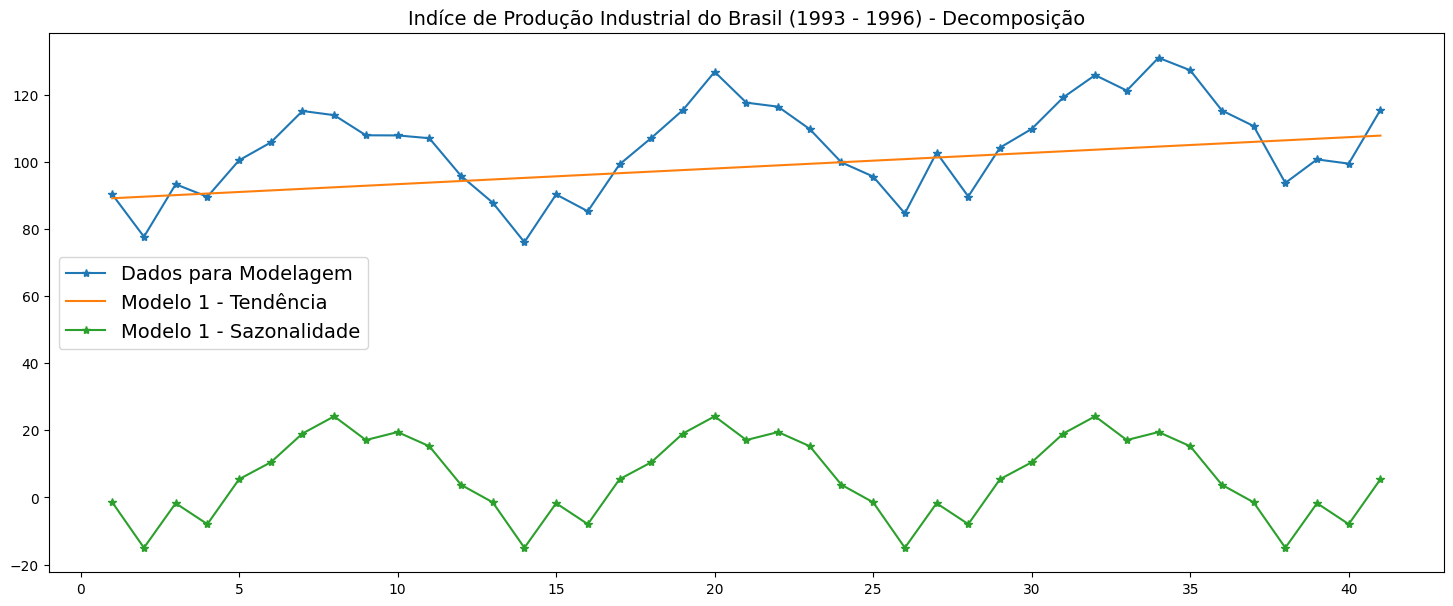

In [82]:
plt.figure(figsize = (18,7))
plt.plot(tModel,ZtModel, label = 'Dados para Modelagem', marker = '*')
plt.plot(tModel,ZtModel_tend, label = 'Modelo 1 - Tendência')
plt.plot(tModel,ZtModel_sazo, label = 'Modelo 1 - Sazonalidade', marker = '*')


plt.title('Indíce de Produção Industrial do Brasil (1993 - 1996) - Decomposição', fontdict= {'size':14})
plt.legend(loc = 'center left', prop = {'size':14})
plt.show()

Text(0.5, 1.0, 'Resíduos do Modelo')

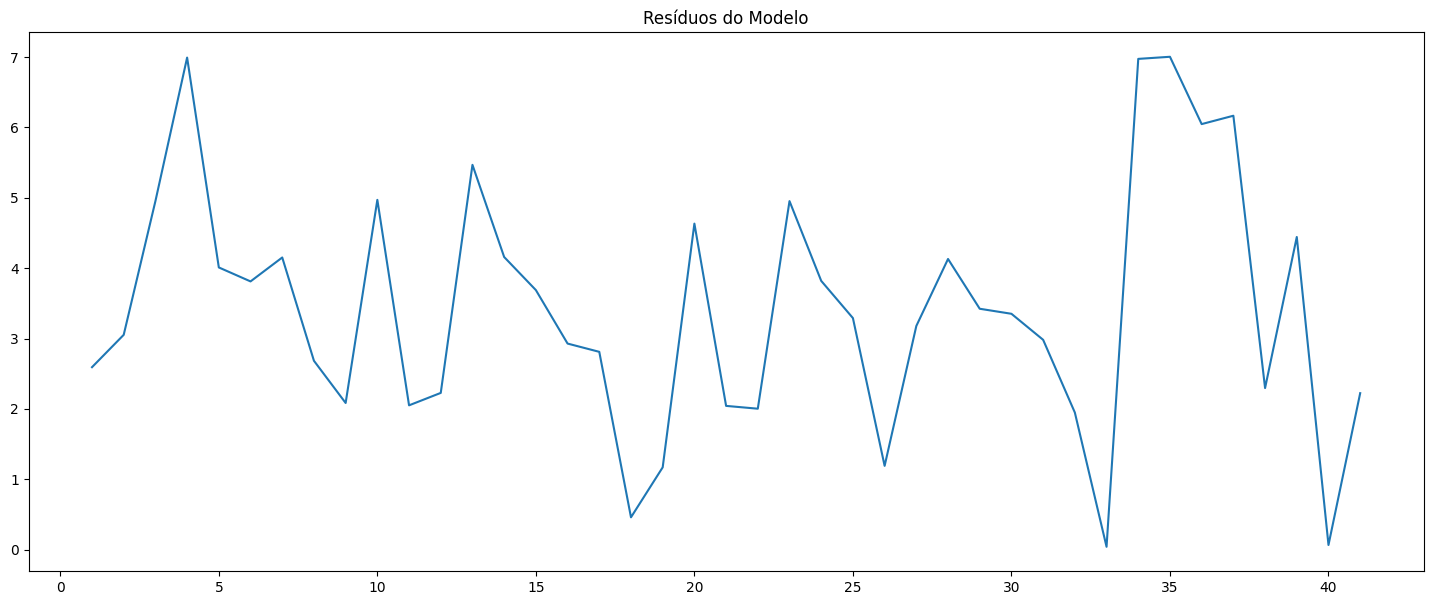

In [83]:
res1 = abs(ZtModel1 - ZtModel)

plt.figure(figsize = (18,7))
plt.plot(tModel,res1)
plt.title('Resíduos do Modelo')

In [84]:
ZtTest1, ZtTest_tend, ZtTest_sazo = polyest_sazo(theta1,tTest,sazonalidade, month_start_test)

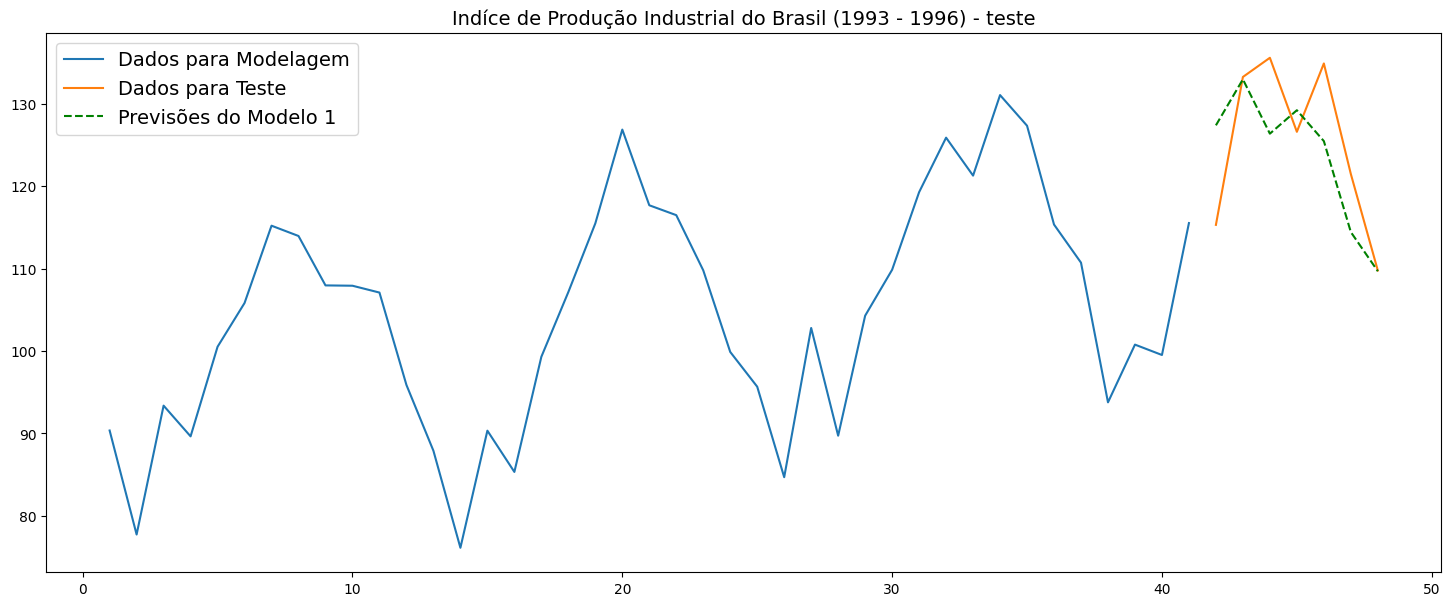

In [85]:
plt.figure(figsize = (18,7))

plt.plot(tModel,ZtModel, label = 'Dados para Modelagem')
plt.plot(tTest,ZtTest, label = 'Dados para Teste')
plt.plot(tTest,ZtTest1, color = 'green', linestyle = 'dashed', label = 'Previsões do Modelo 1')

plt.title('Indíce de Produção Industrial do Brasil (1993 - 1996) - teste', fontdict= {'size':14})
plt.legend(loc = 'upper left', prop = {'size':14})
plt.show()